# Word Embeddings

![](../figs/intro_nlp/embeddings/embeddings.png)

## What are word embeddings?

Word embeddings are a way of representing words as vectors. The vectors are learned from text data and are able to capture some of the semantic and systactic information of the words. 

For example, the word`cat` is similar to `doc` from the following sentences:

"The cat is lying on the floor and the dog was eating”,
 
"The doc was lying on the floor and the cat was eating”

In a mathematical sense, a word embedding is a parameterized function of the word:

$$ f_{\theta}(w) = \theta $$

where $\theta$ is a vector of real numbers. The vector $\theta$ is the embedding of the word $w$.

In a broad sense, `embedding` refers to a lower-dimensional dense vector representation of a higher-dimensional object.
  - in NLP, this higher-dimensional object will be a document.
  - in computer vision, this higher-dimensional object will be an image.

Examples of embeddings and non-embeddings:

  - **Non-embeddings**:
    - one-hot encoding, bag-of-words, TF-IDF, etc.
    - counts over LIWC dictionary categories.
    - sklearn CountVectorizer count vectors
  - **Embeddings**:
    - word2vec, GloVe, BERT, ELMo, etc.
    - PCA reductions of the word count vectors
    - LDA topic shares
    - compressed encodings from an autoencoder



## Categorical Embeddings

![](../figs/intro_nlp/embeddings/1.png)

Categorical embeddings are a way of representing categorical variables as vectors.

For a binary classification problem with outcome $Y$:
    - If you have a high-dimensional categorical variable $X$, (e.g. 1000 categories), you can represent $X$ as a vector of length 1000.
    - It is computationally expensive for a ML model to learn from a high-dimensional categorical variable.

Instead, you can represent $X$ as a lower-dimensional vector of length $k$ (e.g. 10). This is called a categorical embedding. 

Embedding approaches:

1. PCA applied to the dummy variables $X$ to get a lower-dimensional vector representation of $\tilde{X}$.
2. Regress $Y$ on $X$, predict $\hat{Y}(X_i)$, use that as a feature in a new model.



### An embedding layer is matrix multiplication:

$$
\underbrace{h_1}_{n_E \times 1} = \underbrace{\omega_E}_{n_E \times n_W} \cdot \underbrace{x}_{n_x \times 1} 
$$

- $x$ = a categorical variable (e.g., representing a word)
  - One-hot vector with a single item equaling one.
  - Input to the embedding layer.
- $h_1$ = the first hidden layer of the neural net
  - The output of the embedding layer.
- The embedding matrix $\omega_E$ encodes predictive information about the categories.
- It has a spatial interpretation when projected into 2D space.
  - Each row of $\omega_E$ is a vector in $n_E$-dimensional space.
  - The rows of $\omega_E$ are the coordinates of the points in the vector space.
  - The points are the categories.
  - The distance between the points is the similarity between the categories.
  - The angle between the points is the relationship between the categories.

### Embedding Layers versus Dense Layers

An embedding layer is statistically equivalent to a fully-connected dense layer with one-hot vectors as input and linear activation.

- Embedding layers are much faster for many categories (>~50)

## Word Embeddings

> Word embeddings are neural network layers that map words to dense vectors.


Documents are lists of word indexes ${w_1 ,w_2 ,...,w_{n_i} }$.

- Let $w_i$ be a one-hot vector (dimensionality $n_w$ = vocab size) where the associated word’s index equals one.
- Normalize all documents to the same length L; shorter documents can be padded with a null token.
- This requirement can be relaxed with recurrent neural networks.

The embedding layer replaces the list of sparse one-hot vectors with a list of n E -dimensional ($n_E$ << $n_w$ ) dense vectors

$$ \mathbf{X} = [x_1 \ldots x_L ] $$

where

$$
\underbrace{x_j}_{n_E \times 1} = \underbrace{\mathbf{E}}_{n_E \times n_W} \cdot \underbrace{w_j}_{n_w \times 1}
$$

$\mathbf{E}$ a matrix of word vectors. The column associated with the word at $j$ is selected by the dot-product with one-hot vector $w_j$.

$\mathbf{X}$ is flattened into an $L * n_E$ vector for input to the next layer.


![](../figs/intro_nlp/embeddings/4.png)


### Why do we need neural networks for word embeddings?

There are a lot of shallow algorithms that work well for clustering.
- k-means
- hierarchical clustering
- spectral clustering
- PCA

The reasons we use neural networks for word embeddings are:
- They are able to learn the relationships between words.
- They can be used as input to a downstream task.
- They create a mapping of discrete words to continuous vectors.
- They solve the curse of dimensionality.

## Neural Language Models

Word embeddings were proposed by {cite}`bengio2003neural` as a way to represent words as vectors.

Bengio’s method could train a neural network such that each training sentence could inform the model about a number of semantically available neighboring words, which was known as `distributed representation of words`. The nueural network preserved relationships between words in terms of their contexts (semantic and syntactic).

![](../figs/intro_nlp/embeddings/bengio.png)


This introduced a neural network architecture approach that laid the foundation for many current approaches. 

This neural network has three components:
- **Embedding layer**: maps words to vectors, the parameters are shared across the network.
- **Hidden layer**: a fully connected layer with a non-linear activation function.
- **Output layer**: produces a probability distribution over the vocabulary using a softmax function.

### Step 1: Indexing the words. 

For each word in the sentence, we assign an index.

```python
word_list = " ".join(raw_sentence).split()
word_list = list(set(word_list))
word2id = {w: i for i, w in enumerate(word_list)}
id2word = {i: w for i, w in enumerate(word_list)}
n_class = len(word2id)
```

### Step 2: Building the model.

```python
class NNLM(nn.Module):
    def __init__(self):
        super(NNLM, self).__init__()
        self.embeddings = nn.Embedding(n_class, m) #embedding layer or look up table

        self.hidden1 = nn.Linear(n_step * m, n_hidden, bias=False)
        self.ones = nn.Parameter(torch.ones(n_hidden))

        self.hidden2 = nn.Linear(n_hidden, n_class, bias=False)
        self.hidden3 = nn.Linear(n_step * m, n_class, bias=False) #final layer

        self.bias = nn.Parameter(torch.ones(n_class))

    def forward(self, X):
        word_embeds = self.embeddings(X) # embeddings
        X = word_embeds.view(-1, n_step * m) # first layer
        tanh = torch.tanh(self.ones + self.hidden1(X)) # tanh layer
        output = self.bias + self.hidden3(X) + self.hidden2(tanh) # summing up all the layers with bias
        return word_embeds, output
```

- An embedding layer is a lookup table that maps each word to a vector.
- Once the input index of the word is embedded, it is passed through the first hidden layer with bias added to it.
- The output of the first hidden layer is passed through a tanh activation function.
- The output from the embedding layer is also passed through the final layer where the output of the tanh layer is added to it.


### Step 3: Loss and optimization function.

Now that we have the model, we need to define the loss function and the optimization function.

We are using the cross-entropy loss function and the Adam optimizer.

The cross-entropy loss function is made up of two parts:
- The softmax function: this is used to normalize the output of the model so that the sum of the probabilities of all the words in the vocabulary is equal to one.
- The negative log-likelihood: this is used to calculate the loss.



```python
model = NNLM()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
```


### Step 4: Training the model.

Finally, we train the model.


```python
for epoch in range(5000):
    optimizer.zero_grad()
    embeddings, output = model(input_batch)

    # output : [batch_size, n_class], target_batch : [batch_size]
    loss = criterion(output, target_batch)
    if (epoch + 1) % 1000 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

    loss.backward()
    optimizer.step()

# Predict
predict = model(input_batch).data.max(1, keepdim=True)[1]

# Test
print([sen.split()[:2] for sen in raw_sentence], '->', [id2word[n.item()] for n in predict.squeeze()])
```



### Summary

- Word embeddings are a way to represent words as low-dimensional dense vectors.
- These embeddings have associated learnable vectors, which optimize themselves through back propagation. 
- Essentially, the embedding layer is the first layer of a neural network.
- They try to preserve the semantic and syntactic relationships between words.

![](../figs/intro_nlp/embeddings/w2v.png)


## Word2Vec

Word2Vec is a neural network architecture that was proposed by {cite}`mikolov2013distributed` in 2013. It is a shallow, two-layer neural network that is trained to reconstruct linguistic contexts of words.

The problem of the previous neural network is that it is computationally expensive to train. The hidden layer computes probability distribution for all the words in the vocabulary. This is because the output layer is a fully connected layer.

Word2Vec solves this problem by using a single output neuron. This is achieved by using a `hierarchical softmax` or `negative sampling` method.

### Main idea

- Use a `binary classifier` to predict which words appear in the context of (i.e. near) a target word.
- The `parameters of that classifier` provide a dense vector representation of the target word (embedding).
- Words that appear in similar contexts (that have high distributional similarity) will have very similar vector representations.
- These models can be trained on large amounts of raw text (and pre-trained embeddings can be downloaded).

### Negative sampling

Train a binary classifier that decides whether a target word t appears in the context of other words $c_{1..k}$

- `Context`: the set of k words near (surrounding) t
- Treat the target word t and any word that actually appears in its context in a real corpus as `positive` examples
- Treat the target word t and randomly sampled words that don’t appear in its context as `negative` examples
- Train a `binary logistic regression` classifier to distinguish these cases
- The `weights` of this classifier depend on the `similarity` of t and the words in $c_{1..k}$


### Two models

- **Continuous Bag of Words (CBOW)**: predicts the target word from the context words.
- **Skip-gram**: predicts the context words from the target word.

![](../figs/intro_nlp/embeddings/cbow_skip-gram.png)


## Continuous Bag of Words (CBOW)

The CBOW model predicts the target word from the context words.

This model reduces the complexity of calculating the probability distribution for all the words in the vocabulary to the $\log_2(V)$ complexity of calculating the probability distribution for the target word.

### Step 0: Prepare the data

In [12]:
%config InlineBackend.figure_format='retina'

from ekorpkit import eKonf

cfg = eKonf.compose('path')
cfg.cache.uri = 'https://github.com/entelecheia/ekorpkit-book/raw/main/assets/data/us_equities_news_sampled.zip'
corpus = eKonf.load_data("us_equities_news_sampled.parquet", cfg.cached_path)
corpus.text[0]

'Investing com Asian stock markets were broadly lower for a second day on Thursday as weak U S data on durable goods orders added to concerns over the global growth outlook while concerns over declining corporate profits also weighed During late Asian trade Hong Kong s Hang Seng Index tumbled 1 55 Australia s ASX 200 Index dipped 0 1 while Japan s Nikkei 225 Index shed 0 7 The Nikkei came further off a one year closing high hit earlier in the week as investors cashed in ahead of the Japanese fiscal year end March is the final month of Japan s fiscal year and market participants have expected many funds to lock in profits from a meteoric 19 rally in the January to March period after shedding more than 13 in April to December Exporters which have gained sharply in the first quarter on the back a weakening yen declined Automakers Toyota and Nissan slumped 1 65 and 1 8 respectively while consumer electronics giant Sony retreated 1 5 On the upside Sharp saw shares jump 6 7 extending the pre

In [2]:
words = corpus.text[0].lower().split()
# By deriving a set from `words`, we deduplicate the array
vocab = set(words)
vocab_size = len(vocab)

word_list = list(vocab)

word_to_ix = {word: ix for ix, word in enumerate(vocab)}
ix_to_word = {ix: word for ix, word in enumerate(vocab)}

### Step 1: Define a function to create a context and a target word

Define a function to create a context window with n words from the right and left of the target word.

The function should take two arguments: data and window size. The window size will define how many words we are supposed to take from the right and from the left. 

The for loop: `for i in range(window_size, len(words) – window_size)`: iterates through a range starting from the window size, i.e. 2 means it will ignore words in index 0 and 1 from the sentence, and end 2 words before the sentence ends. 

Inside the for loop, we try separate context and target words and store them in a list.

For example, if we have the sentence “I like deep learning because it is fun”, and the window size is 2, the function will return the following list:

```python
[(['I', 'like', 'learning', 'because'], 'deep'),
 (['like', 'deep', 'because', 'it'], 'learning'),
 (['deep', 'learning', 'it', 'is'], 'because'),
 (['learning', 'because', 'is', 'fun'], 'it')]
```

In [4]:
def CBOW(words, window_size=2):
    data = []
    for i in range(window_size, len(words) - window_size):
        context = [
            words[i - window_size],
            words[i - (window_size - 1)],
            words[i + (window_size - 1)],
            words[i + window_size],
        ]
        target = words[i]
        data.append((context, target))

    return data

Let’s call the function and see the output. 

In [5]:
CBOW("I like deep learning because it is fun".split())

[(['I', 'like', 'learning', 'because'], 'deep'),
 (['like', 'deep', 'because', 'it'], 'learning'),
 (['deep', 'learning', 'it', 'is'], 'because'),
 (['learning', 'because', 'is', 'fun'], 'it')]

### Step 2: Build the model

In the CBOW model, we reduce the hidden layer to only one. So all together we have: an embedding layer, a hidden layer which passes through the ReLU layer, and an output layer.

The context words index is fed into the embedding layers, which is then passed through the hidden layer followed by the nonlinear activation layer, i.e. ReLU, and finally we get the output.

In [6]:
import torch
import torch.nn as nn


def make_context_vector(context, word_to_ix):
    idxs = [word_to_ix[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long)


class CBOW_Model(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW_Model, self).__init__()

        # out: 1 x emdedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, 128)
        self.activation_function1 = nn.ReLU()

        # out: 1 x vocab_size
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = sum(self.embeddings(inputs)).view(1, -1)
        out = self.linear1(embeds)
        out = self.activation_function1(out)
        out = self.linear2(out)
        return out

    def get_word_emdedding(self, word):
        word = torch.tensor([word_to_ix[word]])
        return self.embeddings(word).view(1, -1)

### Step 3: Loss and optimization function. 

We are using the cross-entropy loss function and the SGD optimizer. You can also use the Adam optimizer.

In [7]:
CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right
EMDEDDING_DIM = 100


data = CBOW(words)
model = CBOW_Model(vocab_size, EMDEDDING_DIM)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

### Step 4: Training the model.

Finally, we train the model.

`make_context_vector` turns words into numbers. 


In [10]:
# TRAINING
for epoch in range(50):
    total_loss = 0

    for context, target in data:
        context_vector = make_context_vector(context, word_to_ix)

        log_probs = model(context_vector)

        total_loss += loss_function(log_probs, torch.tensor([word_to_ix[target]]))

    # optimize at the end of each epoch
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, Loss: {total_loss.item()}")

Epoch: 0, Loss: 4.84812593460083
Epoch: 10, Loss: 4.375508785247803
Epoch: 20, Loss: 4.032909393310547
Epoch: 30, Loss: 3.749638080596924
Epoch: 40, Loss: 3.5140340328216553


### Visualizing the embeddings

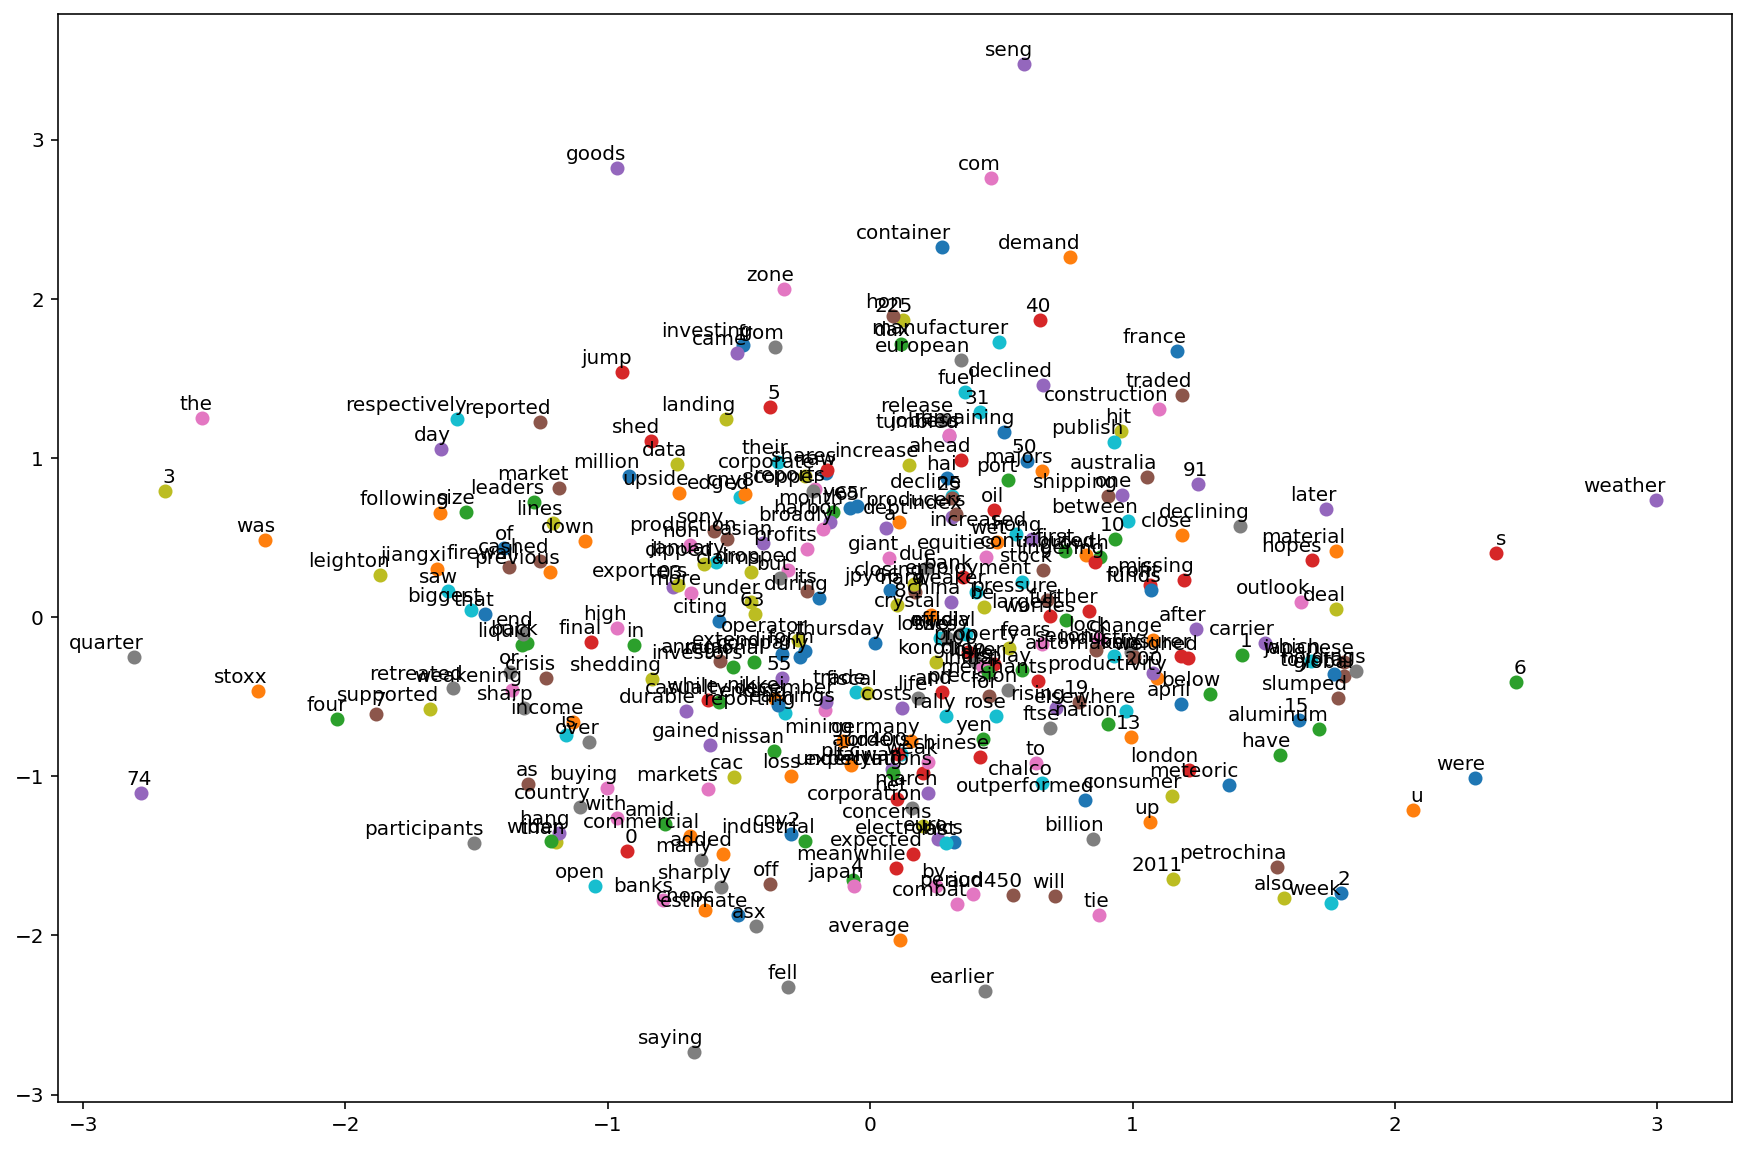

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

for w in word_list:
    x = model.get_word_emdedding(w).detach().data.numpy()[0][0]
    y = model.get_word_emdedding(w).detach().data.numpy()[0][1]
    plt.scatter(x, y)
    plt.annotate(
        w, xy=(x, y), xytext=(5, 2), textcoords="offset points", ha="right", va="bottom"
    )
plt.show()

### Evaluation

In [14]:
def CBOW_test(test_data, model):
    correct_ct = 0

    for context, target in data:
        context_vector = make_context_vector(context, word_to_ix)
        model.zero_grad()
        predicted = torch.argmax(model(context_vector), 1)

        if predicted[0] == torch.tensor([word_to_ix[target]]):
            correct_ct += 1

    print(
        "Accuracy: {:.1f}% ({:d}/{:d})".format(
            correct_ct / len(test_data) * 100, correct_ct, len(test_data)
        )
    )

In [15]:
CBOW_test(data, model)

Accuracy: 99.8% (570/571)


In [16]:
# TESTING
context = ["investing", "com", "stock", "markets"]
context_vector = make_context_vector(context, word_to_ix)
a = model(context_vector)

In [17]:
# Print result
print(f"Context: {context}\n")
print(f"Prediction: {ix_to_word[torch.argmax(a[0]).item()]}")

Context: ['investing', 'com', 'stock', 'markets']

Prediction: asian


## Skip-gram model

The skip-gram model is the same as the CBOW model with one difference: it predicts the context words from the target word.

## References

- [Word2Vec](https://arxiv.org/abs/1301.3781)
- [FastText](https://fasttext.cc/)
- [A Visual Guide to FastText Word Embeddings](https://amitness.com/2020/06/fasttext-embeddings/)
- [Get FastText representation from pretrained embeddings with subword information](http://christopher5106.github.io/deep/learning/2020/04/02/fasttext_pretrained_embeddings_subword_word_representations.html)
- [The Ultimate Guide to Word Embeddings](https://neptune.ai/blog/word-embeddings-guide)
- [Neural Network Language Model.ipynb](https://colab.research.google.com/drive/12TQ4CmY6jUnFlQZFnKenmKL3UdTkcatx?usp=sharing#scrollTo=bxwcGfO8eI6G)